In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

### Problem Statement

[Rain or Shine](https://www.rainorshineicecream.com) is an ice cream shop with 3 locations in Vancouver. The business is open all year and the daily revenue depends on the weather. In particular, revenue increases with temperature and decreases with precipitation. The data file `weather.csv` includes daily average temperature (in degrees Celsius) and daily precipitation (in millimeters) from January 1, 1997 through December 31, 2022. Construct a mathematical model of total annual revenue at one of the shop locations.

### Variables and Parameters

| Description | Symbol | Dimensions | Type |
| :---: | :---: | :---: | :---: |
| average daily temperature | $T$| $\Theta$ | random variable |
| total daily precipitation | $P$| L | random variable |
| reference temperature | $T_0$ | $\Theta$ | parameter |
| reference precipitation | $P_0$ | L | parameter |
| reference number of customers | $C_0$ | N | parameter |
| total revenue | $R$| $1$ | random variable |
| a | $a$| $1$ | parameter |
| b | $b$| $1$ | parameter |

**Formula:** 

$R_i = 10 * max\{C_0 + a(T - T_0) - b(P - P_0),0\}$

$R_{total} = \sum \limits_{i = 1}^{365} R_i$

### Assumptions and Constraints

* Daily precipitation follows a gamma distribution $\Gamma(\alpha,\beta)$
* Daily customers function is linear with respect to temperature and precipitation
* Daily customers function take the form $C(T,P) = \max \{ c(T,P) , 0 \}$ where $c(T,P) = C_0 + a(T - T_0) - b(P - P_0)$
* On a nice day where the average temperature is $T_0 = 25$ and precipitation is $P_0 = 0$ the total number of customers is $C_0 = 720$ (which corresponds to serving one customer per minute over a 12 hour business day)
* $T$ and $P$ on any given day are independent
* Each customer spends 10 dollars
* Total Revenue $= 10 * C(T,P)$

### Build Solutions

In [3]:
df = pd.read_csv('weather.csv')
df.head()

,year,month,day,avg_temperature,precipitation
0,2022,12,31,5.90,3.8
1,2022,12,30,7.80,12.7
2,2022,12,29,4.84,2.9
3,2022,12,28,5.80,3.8
4,2022,12,27,8.10,28.8


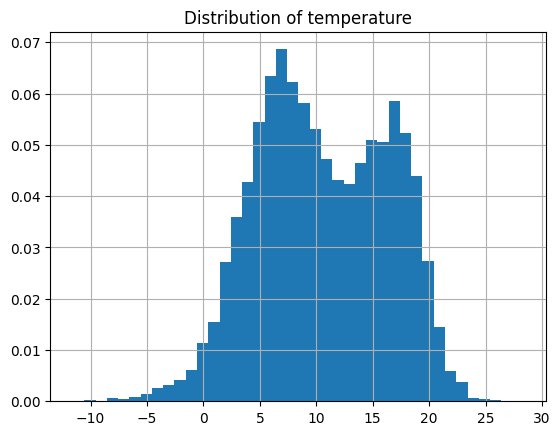

In [4]:
# histogram of temperature data
plt.hist(df['avg_temperature'], bins=40, density=True)
plt.title('Distribution of temperature')
plt.grid()
plt.show()

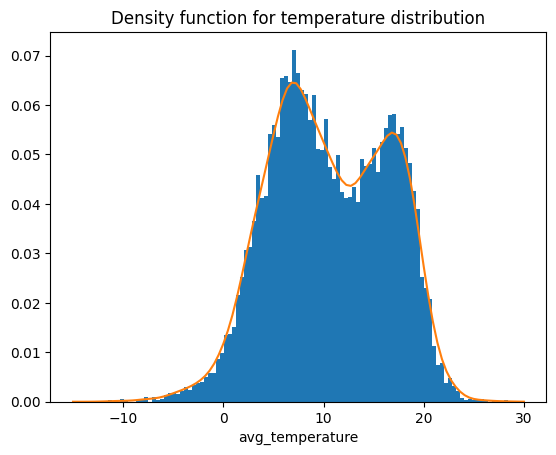

In [6]:
kde_y = stats.gaussian_kde(df['avg_temperature'])
x = np.linspace(-15,30, 100)
df['avg_temperature'].hist(bins=100,density=True)
plt.plot(x,kde_y(x))
plt.xlabel('avg_temperature')
plt.title('Density function for temperature distribution')
plt.grid()
plt.show()

Note: We expect the parameter $\alpha < 1$ therefore the probability distribution $f(x)$ satistifes $\lim \limits_{x \to 0^+} f(x) = \infty$.

In [8]:
# compute mean of precipitation
mu_p = df['precipitation'].mean()
print(mu_p)
var_p = df['precipitation'].var()
print(var_p)

3.2037068239258635
41.88987356711931


In [10]:
# fit into gamma distribution
alpha = mu_p**2/var_p**2
beta = mu_p/var_p**2
print(alpha)
print(beta)

0.005849078276438689
0.0018257220769256138


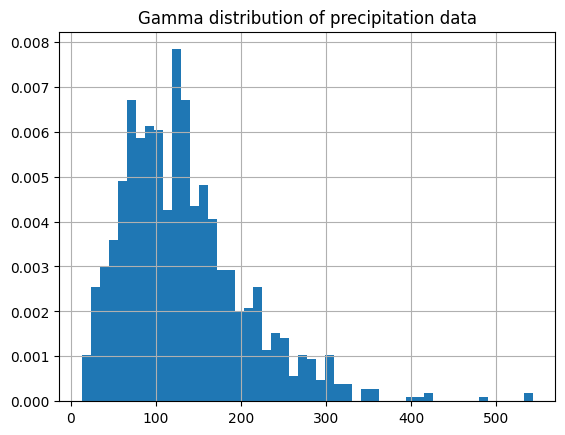

In [27]:
import scipy.special as sps
y = np.random.gamma(mu_p, var_p, 1000)
plt.hist(y, bins=50, density=True)
plt.title('Gamma distribution of precipitation data')
plt.grid(True)
plt.show()

$$
R_{total} = \sum \limits_{i = 1}^{365} R_i
$$

where $R_i$ is the revenue on day $i$.

In [31]:
kdeP = stats.gaussian_kde(df['precipitation'])
Ys = []
# creating samples
# $R_i = 10 * max\{C_0 + a(T - T_0) - b(P - P_0),0\}$
# $R_i = 10 * max\{C_0 + T - T_0 - P),0\}$
# assume a = b = 1
for i in range(2000):
    T = kde_y.resample(size=365).flatten()
    P = kdeP.resample(size=365).flatten()
    c = np.sum(720 + T - 25 - P)
    Y = np.maximum(c,0)
    Ys.append(Y)

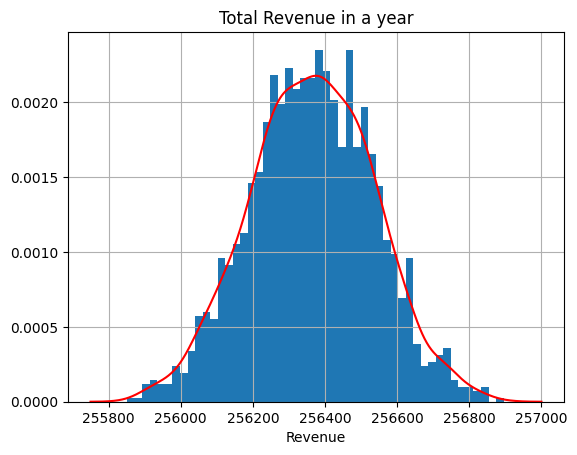

In [38]:
kdeY = stats.gaussian_kde(Ys)
x = np.linspace(255750,257000,1000)
plt.hist(Ys, bins=50, density=True)
plt.plot(x,kdeY.pdf(x),'r')
plt.title('Total Revenue in a year')
plt.xlabel('Revenue')
plt.grid(True)
plt.show()

### Analysis

* Find a value $R_0$ such that $P(R > R_0) = 0.9$
* How do the values $a$ and $b$ change the model?
* How do the values $C_0$, $T_0$ and $P_0$ change the model?
* How does the model change if we assume that the amount each customer spends is normally distributed?
* What are other forms of the function $C(T,P)$ are reasonable to model the number of customers per day?

In [40]:
from scipy.integrate import quad
mean,_ = quad(lambda x: x*kdeY.pdf(x),255750,257000)
mean

256364.11979440297

In [63]:
a = 227
kdeY.integrate_box_1d(mean-a, 257000)

0.9004701985561555

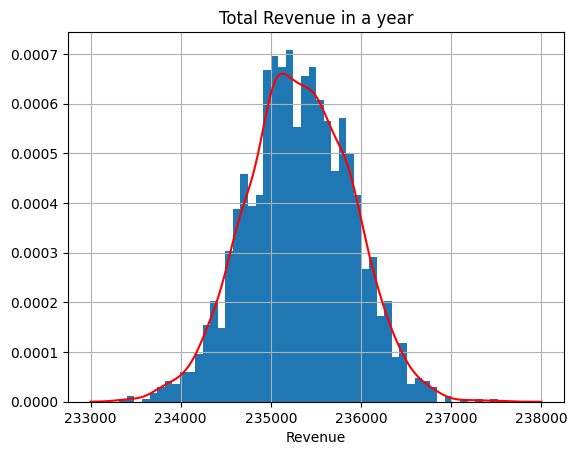

In [77]:
kdeP = stats.gaussian_kde(df['precipitation'])
Ys = []
# change a = 1 and b = 5
a = 5
b = 1
for i in range(2000):
    T = kde_y.resample(size=365).flatten()
    P = kdeP.resample(size=365).flatten()
    c = np.sum(720 + a * T - a * 25 - b * P)
    Y = np.maximum(c,0)
    Ys.append(Y)
    
kdeY = stats.gaussian_kde(Ys)
x = np.linspace(233000,238000,10000)
plt.hist(Ys, bins=50, density=True)
plt.plot(x,kdeY.pdf(x),'r')
plt.title('Total Revenue in a year')
plt.xlabel('Revenue')
plt.grid(True)
plt.show()

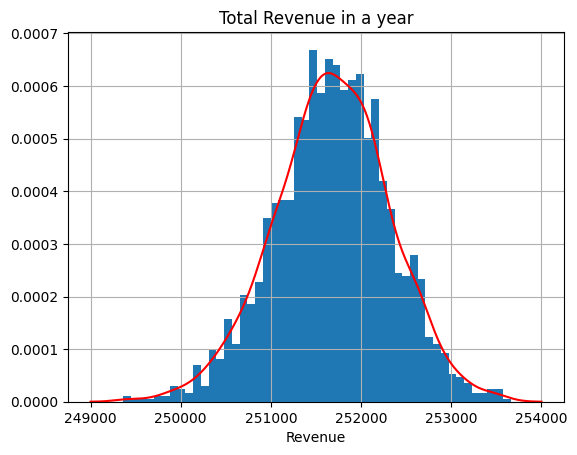

In [79]:
kdeP = stats.gaussian_kde(df['precipitation'])
Ys = []
# change a = 1 and b = 5
a = 1
b = 5
for i in range(2000):
    T = kde_y.resample(size=365).flatten()
    P = kdeP.resample(size=365).flatten()
    c = np.sum(720 + a * T - a * 25 - b * P)
    Y = np.maximum(c,0)
    Ys.append(Y)
    
kdeY = stats.gaussian_kde(Ys)
x = np.linspace(249000,254000,1000)
plt.hist(Ys, bins=50, density=True)
plt.plot(x,kdeY.pdf(x),'r')
plt.title('Total Revenue in a year')
plt.xlabel('Revenue')
plt.grid(True)
plt.show()

Increasing the values of a will cause the total revenue to decrease because it will place greater importance on temperature. Increasing the values of b will cause the total revenue to decrease as well because the function will place importance on precipitation which decreases the total revenue. 

We would expect that increasing $C_0$ will increase revenue since more customers will come on an ideal temperature. 

### Results

Overall, the model could be more complex depending on the parameters of a and b because it depends on how important precipitation and temperature is. However, increasing both a and b will decrease the total revenue which makes sense because customers are more unlikely to order ice cream on an unpleasant weather and more likely to order on hot weather. Furthermore, the values of $T_0$ and $P_0$ is subjective to each customers. 